<a href="https://colab.research.google.com/github/HuyenNguyenHelen/ABSA-BERT-pair/blob/master/SciBERT_SeqClassifier_Final_DS_6classes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set up

In [ ]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import io

In [ ]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [ ]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla K80


In [ ]:
!pip install transformers

# Loading the dataset

In [ ]:
# Downloading the csv file from your GitHub account


data_url = 'https://raw.githubusercontent.com/HuyenNguyenHelen/Sentence_contribution_classification/main/IPM_ACL_5Categories.csv'
def loadFile (url):
  download = requests.get(url).content
  df = pd.read_csv(io.StringIO(download.decode('utf-8')))
  print(df.shape)
  return df
df = loadFile (data_url)
df.columns = ['Sentence', 'Source', 'Label']
print(df.shape)
df.head()

df = df.dropna() #[ ['Sentence', 'Label']]
df['Label'] = df['Label'].replace('applications', 'Applications')
df['Label'] = df['Label'].replace('Performance evaluation', 'Performance Evaluation')
df['Label'] = df['Label'].replace('theory Proposal', 'Theory Proposal')
df.head()

(4837, 3)
(4837, 3)


,Sentence,Source,Label
0,We propose a Combinatorial visuaL Analytics sy...,IPM,Model Construction or Optimization
1,we performed a transcriptome analysis of glome...,IPM,Performance Evaluation
2,We conducted both in vitro and in vivo experim...,IPM,Theory Proposal
3,we report accumulation of actinoplanic acid A ...,IPM,Theory Proposal
4,we have identified the APL cluster in other ba...,IPM,Theory Proposal


# Expolatory Data Analysis

In [ ]:
#checking missing values
print('Before: \n', df.isnull().sum() )
df = df.dropna(subset = ['Sentence'])      
print('After: \n', df.isnull().sum() )

Before: 
 Sentence    0
Source      0
Label       0
dtype: int64
After: 
 Sentence    0
Source      0
Label       0
dtype: int64


In [ ]:
# checking duplicate rows
print("number of duplicates before dropping: ", df[df.duplicated()].shape)

# Droping duplicates
df = df.drop_duplicates()
print("number of duplicates after dropping: ", df[df.duplicated()].shape)

number of duplicates before dropping:  (1, 3)
number of duplicates after dropping:  (0, 3)


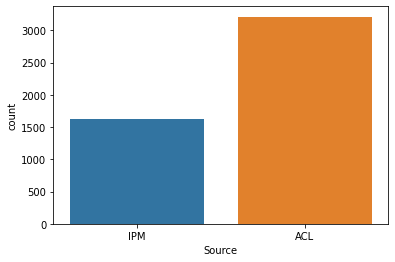

In [ ]:
sns.countplot(x='Source', data=df)
plt.show()

In [ ]:
print(df['Label'].value_counts())

Theory Proposal                                     1340
Algorithms/ Methods Construction or Optimization    1246
Model Construction or Optimization                  1041
Performance Evaluation                               617
Dataset Creation or Resources                        442
Applications                                         150
Name: Label, dtype: int64


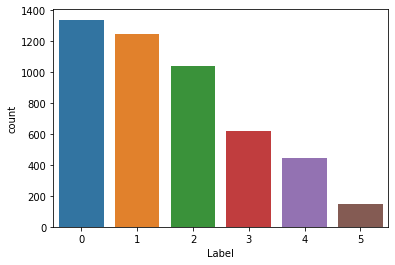

In [ ]:
label_dic = {'Theory Proposal':0,
             'Algorithms/ Methods Construction or Optimization':1,
             'Model Construction or Optimization':2,
             'Performance Evaluation':3,
             'Dataset Creation or Resources': 4,
             'Applications': 5}
df['Label'] = df['Label'].map(label_dic)
sns.countplot(x='Label', data=df)
plt.show()


# Data Pre-processing

## Spliting dataset into training (90%) and testing sets (10%)

In [ ]:
# from sklearn.preprocessing import LabelEncoder
# encoder = LabelEncoder()
# labels = encoder.fit_transform(df['Label'])
# from sklearn.model_selection import train_test_split
# X = df['Sentence']
# y = labels

# train_sentences, test_sentences, train_labels, test_labels = train_test_split (X, y, train_size = 0.8, random_state = 42, shuffle = True, stratify=y)
# print ('Shapes of X_train, y_train: ', train_sentences.shape, train_labels.shape)
# print ('Shapes of X_test, y_test: ', test_sentences.shape, test_labels.shape)

In [ ]:
size_trainset = int(len(df) * 0.8)
size_testset = len(df) - size_trainset
train_set = df.sample(frac = 0.8, random_state = 42)
test_set = df.drop(train_set.index)

print(train_set.shape, test_set.shape)


(3869, 3) (967, 3)


# BERT - Sequence Classification

In [ ]:
# Training set: Get the lists of sentences and their labels.
train_sentences = train_set.Sentence.values
train_labels = train_set.Label.values

# Test set: Get the lists of sentences and their labels.
test_sentences = test_set.Sentence.values
test_labels = test_set.Label.values

### Tokenization and input formating

In [ ]:
from transformers import BertTokenizer
from transformers import AutoTokenizer, AutoModel


##### Load the SciBERT tokenizer.
print('Loading SciBERT tokenizer...')

# Load pretrained model/tokenizer
### SciBERT
tokenizer = AutoTokenizer.from_pretrained('allenai/scibert_scivocab_uncased')

##### Get the max length of sentences
max_len = 0
# For every sentence...
for sent in train_sentences:
    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Loading SciBERT tokenizer...
Max sentence length:  173


In [ ]:
# Tokenize all of the sentences and map the tokens to their word IDs.
input_ids = []
attention_masks = []
# For every sentence...
for sent in train_sentences:
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 128,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(train_labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', train_sentences[0])
print('Token IDs:', input_ids[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2204: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  Document clustering with document embedding representations combined with k-means clustering delivered the best performance.
Token IDs: tensor([  102,  3367,  5166,   190,  3367, 10191,  6859,  3109,   190,   231,
          579,  2033,  5166,  8299,   111,  2172,  1150,   205,   103,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,   

### Training and Validation

In [ ]:
### Split our dataset into training and testing
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 80-20 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

3,095 training samples
  774 validation samples


In [ ]:
### Creating batches for iterating to train
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [ ]:
##### Train BERT for Sequence Classification model
from transformers import AutoConfig, AutoModelForSequenceClassification, AdamW # BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top. 

model = AutoModelForSequenceClassification.from_pretrained('allenai/scibert_scivocab_uncased',
                                                           num_labels = 6, 
                                                           output_attentions=False,
                                                           output_hidden_states = False )

# Tell pytorch to run this model on the GPU.
model.cuda()

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification we

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31090, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (31090, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

In [ ]:
##### Optimizing and setting learning rate

optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
epochs = 10
# Total number of training steps is [number of batches] x [number of epochs]. 
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, 
                                            num_training_steps = total_steps)


In [ ]:
##### Training
import numpy as np
import time
import datetime
import random
import numpy as np

# to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)



# to observe time of training
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))




In [ ]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # In PyTorch, calling `model` will in turn call the model's `forward` 
        # function and pass down the arguments. The `forward` function is 
        # documented here: 
        # https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification
        # The results are returned in a results object, documented here:
        # https://huggingface.co/transformers/main_classes/output.html#transformers.modeling_outputs.SequenceClassifierOutput
        # Specifically, we'll get the loss (because we provided labels) and the
        # "logits"--the model outputs prior to activation.
        result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       labels=b_labels,
                       return_dict=True)

        loss = result.loss
        logits = result.logits

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            result = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)

        # Get the loss and "logits" output by the model. The "logits" are the 
        # output values prior to applying an activation function like the 
        # softmax.
        loss = result.loss
        logits = result.logits
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 10 ========
Training...
  Batch    40  of     97.    Elapsed: 0:00:48.
  Batch    80  of     97.    Elapsed: 0:01:37.

  Average training loss: 1.38
  Training epcoh took: 0:01:57

Running Validation...
  Accuracy: 0.60
  Validation Loss: 1.14
  Validation took: 0:00:11

======== Epoch 2 / 10 ========
Training...
  Batch    40  of     97.    Elapsed: 0:00:48.
  Batch    80  of     97.    Elapsed: 0:01:37.

  Average training loss: 1.07
  Training epcoh took: 0:01:57

Running Validation...
  Accuracy: 0.61
  Validation Loss: 1.09
  Validation took: 0:00:11

======== Epoch 3 / 10 ========
Training...
  Batch    40  of     97.    Elapsed: 0:00:49.
  Batch    80  of     97.    Elapsed: 0:01:37.

  Average training loss: 0.88
  Training epcoh took: 0:01:57

Running Validation...
  Accuracy: 0.61
  Validation Loss: 1.12
  Validation took: 0:00:11

======== Epoch 4 / 10 ========
Training...
  Batch    40  of     97.    Elapsed: 0:00:49.
  Batch    80  of     97.    Elapsed

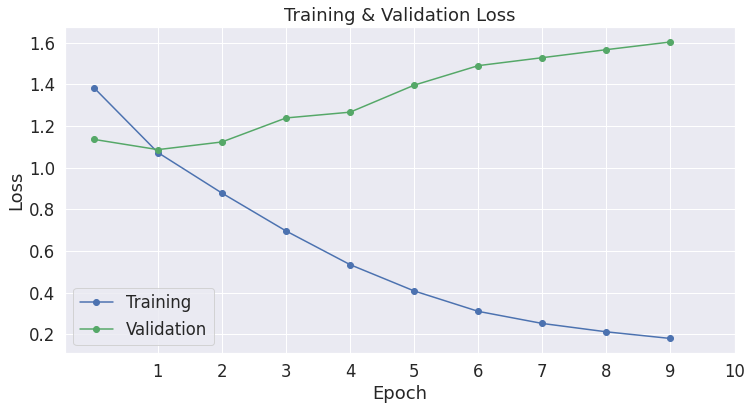

In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns
df_stats = pd.DataFrame(data=training_stats)

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4,5,6,7,8,9,10])

plt.show()

### Testing

In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids_test = []           
attention_masks_test = []

# For every sentence...
for sent in test_sentences:
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids_test.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks_test.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids_test = torch.cat(input_ids_test, dim=0)
attention_masks_test = torch.cat(attention_masks_test, dim=0)
labels = torch.tensor(test_labels)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(input_ids_test, attention_masks_test, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2204: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids_test)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []
# get predictions for test data
# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions.
      result = model(b_input_ids, 
                     token_type_ids=None, 
                     attention_mask=b_input_mask,
                     return_dict=True)

  logits = result.logits

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 967 test sentences...
    DONE.


In [ ]:
# Combine the results across all batches. 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

# Printing model performance 
def printing_eval_scores (y_true, y_pred):
  print('accuracy score: {}'.format(accuracy_score(y_true, y_pred)))
  print('precision score: {}'.format(precision_score(y_true, y_pred, average = 'weighted', zero_division=1)))
  print('recall score: {}'.format(recall_score(y_true, y_pred,  average = 'weighted', zero_division=1)))
  print('F1 score: {}'.format(f1_score(y_true, y_pred,  average = 'weighted', zero_division=1)))
  print(classification_report(y_true, y_pred))

printing_eval_scores (flat_true_labels, flat_predictions)
# print(accuracy_score(flat_predictions, flat_true_labels))
# print(classification_report(flat_true_labels, flat_predictions))

accuracy score: 0.5604963805584281
precision score: 0.5546525385333725
recall score: 0.5604963805584281
F1 score: 0.5568004733899575
              precision    recall  f1-score   support

           0       0.58      0.57      0.58       267
           1       0.54      0.59      0.57       268
           2       0.62      0.63      0.62       207
           3       0.49      0.46      0.48       114
           4       0.55      0.56      0.56        80
           5       0.19      0.10      0.13        31

    accuracy                           0.56       967
   macro avg       0.50      0.49      0.49       967
weighted avg       0.55      0.56      0.56       967



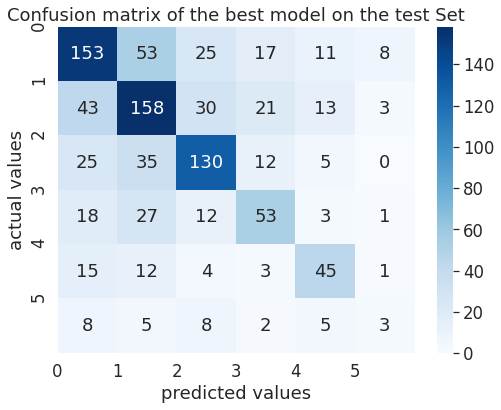

In [ ]:
# Plot confusion matrix on the test set
from sklearn.metrics import confusion_matrix

# Evaluating the model with confusion matrix
conf_matrix = confusion_matrix(flat_true_labels, flat_predictions)

## Visualizing the confusion matrix
label_names = [i for i in range(0,6)]
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot = True, fmt=".0f", cmap = 'Blues' )
tick_marks = np.arange(len(label_names))
plt.xticks(tick_marks, label_names)
plt.yticks(tick_marks, label_names)
plt.xlabel ('predicted values')
plt.ylabel ('actual values')
plt.title('Confusion matrix of the best model on the test Set')
plt.show()